In [82]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess
from scipy.linalg import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt

starry.config.quiet = True
np.random.seed(1)

In [2]:
# Planet orbit
p_inc = 88.0
p_ecc = 0.2
p_Omega = 30.0
p_w = 30.0
p_porb = 1.0
p_t0 = 0.5
p_r = 0.1

# Star
s_inc = 75
s_u = [0.4, 0.2]
s_prot = 4.3

# Gaussian process for the spots
gp_mu = 30.0
gp_sig = 5.0
gp_r = 10.0
gp_c = 0.1
gp_n = 10.0

# Time array (10 days @ 1 min cadence)
t = np.arange(0, 10, 1 / 24 / 60)

In [3]:
# Get the Cartesian position of the planet
star = starry.Primary(starry.Map())
planet = starry.Secondary(
    starry.Map(),
    inc=p_inc,
    ecc=p_ecc,
    Omega=p_Omega,
    w=p_w,
    porb=p_porb,
    t0=p_t0
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]

In [46]:
# Get the flux design matrix
map = starry.Map(15, len(s_u))
map.inc = s_inc
for n, coeff in enumerate(s_u):
    map[n + 1] = coeff
theta = (360 * t / s_prot) % 360
A = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

In [47]:
# Draw 10 samples from the GP
sp = StarryProcess(mu=gp_mu, sigma=gp_sig, r=gp_r, c=gp_c, n=gp_n)
y = sp.sample_ylm(nsamples=10).eval().T

In [48]:
# Starry process Ylms are normalized so that they have
# zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
# Let's renormalize it to unity, since that's the baseline
# we want for transits
y[0] += 1

In [49]:
# Compute the light curves
flux0 = (A @ y).T

In [50]:
error = 1e-3
err = np.ones_like(flux0) * error
flux = np.array(flux0)
flux += np.random.randn(len(t)) * err

In [51]:
flux.shape

(10, 14401)

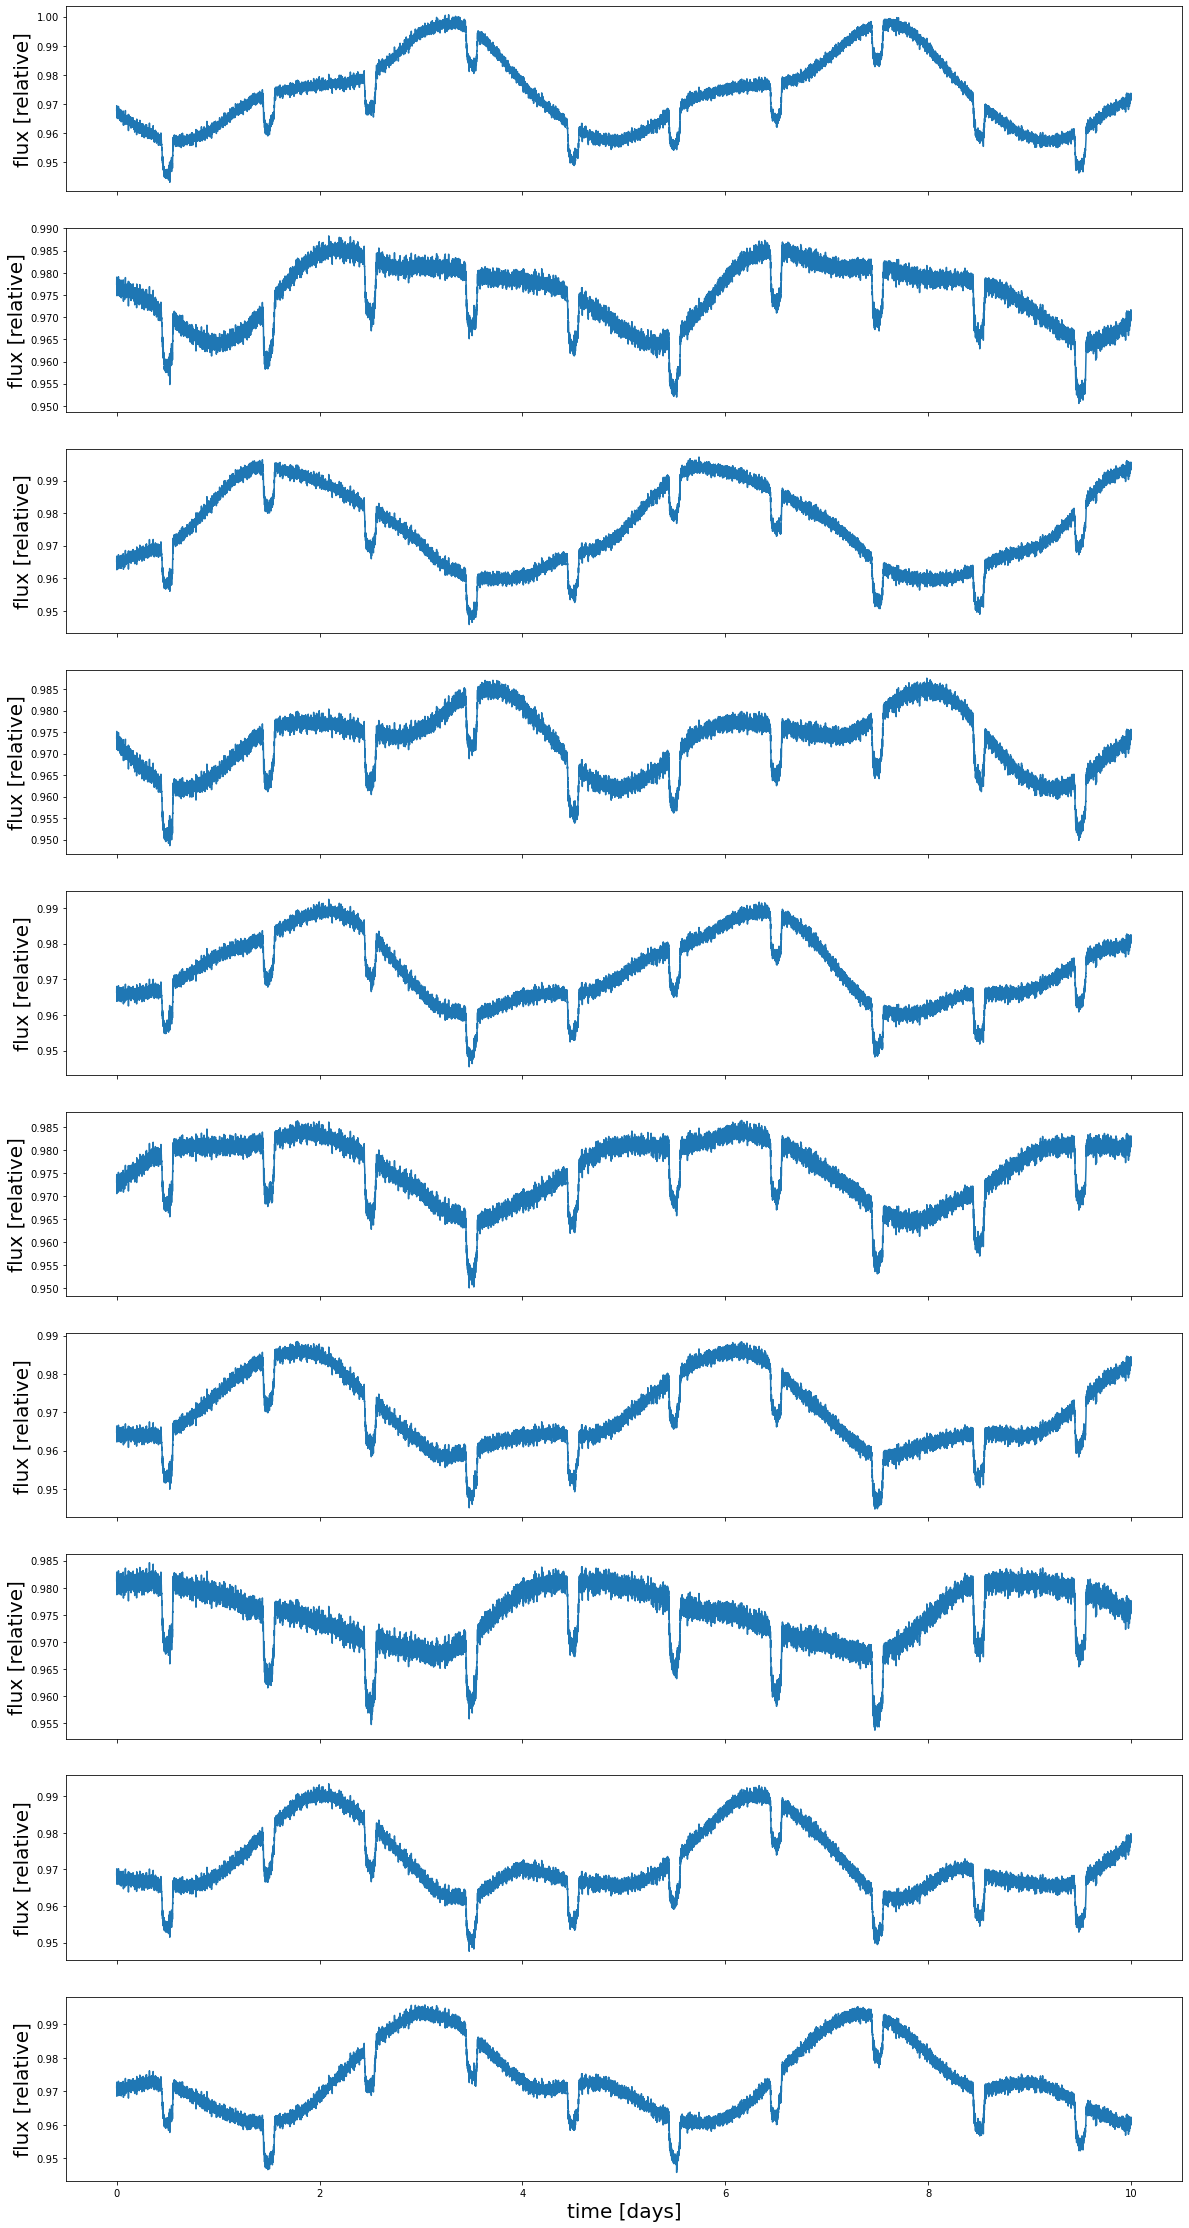

In [52]:
# Plot them
fig, ax = plt.subplots(10, figsize=(20, 40), sharex=True)
for n in range(len(flux)):
    ax[n].plot(t, flux[n])
    ax[n].set_ylabel("flux [relative]", fontsize=20)
ax[-1].set_xlabel("time [days]", fontsize=20);

In [53]:
flux[0].shape

(14401,)

In [54]:
t.shape

(14401,)

In [55]:
Sigma_ylm = sp.cov_ylm

In [56]:
Sigma_ylm.eval().shape

(256, 256)

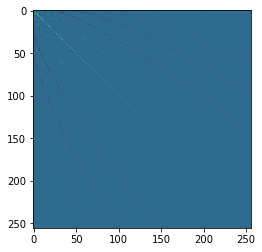

In [15]:
plt.imshow(Sigma_ylm.eval())

In [16]:
Sigma_cho = sp.cho_cov_ylm.eval()

In [17]:
Sigma = A @ Sigma_ylm.eval() @ np.transpose(A)

In [18]:
Sigma+=1

In [19]:
err.shape

(10, 14401)

In [20]:
np.eye(10,14401).shape

(10, 14401)

In [21]:
Sigma.shape

(14401, 14401)

In [22]:
Sigma += err[0]**2*np.eye(len(t))

In [23]:
np.linalg.slogdet(Sigma)

(1.0, -198741.11323660205)

In [24]:
cho_factor(Sigma,lower=True)

(array([[1.00005620e+00, 1.00011140e+00, 1.00011140e+00, ...,
         9.99956148e-01, 9.99956100e-01, 9.99956052e-01],
        [1.00005520e+00, 1.41427458e-03, 1.00011140e+00, ...,
         9.99956196e-01, 9.99956148e-01, 9.99956100e-01],
        [1.00005520e+00, 7.07321061e-04, 1.22490421e-03, ...,
         9.99956245e-01, 9.99956196e-01, 9.99956148e-01],
        ...,
        [9.99899954e-01, 7.41068441e-04, 4.67289955e-04, ...,
         1.00064993e-03, 1.00011140e+00, 1.00011140e+00],
        [9.99899906e-01, 7.41011576e-04, 4.67191486e-04, ...,
         1.30045690e-06, 1.00065013e-03, 1.00011140e+00],
        [9.99899858e-01, 7.40954740e-04, 4.67093066e-04, ...,
         1.30144035e-06, 1.30087131e-06, 1.00065034e-03]]),
 True)

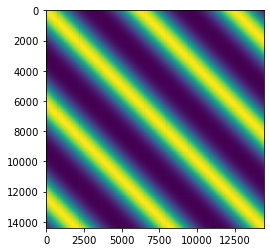

In [25]:
plt.imshow(Sigma)

In [26]:
# Compute the marginal likelihood
mean = A @ sp.mean_ylm.eval() + 1
N = len(t)
def ln_likelihood_dumb(t, y, sigma, **kwargs): #sigma is covariance here
    return -1/2*np.dot(np.dot((y-mean).T,np.linalg.inv(sigma)),(y-mean)) -1/2*np.linalg.slogdet(sigma)[1]-N/2*np.log(2*np.pi)

In [27]:
mean1 = tt.reshape(A @ sp.mean_ylm.eval() + 1, (len(t), 1))

In [28]:
mean.shape

(14401,)

In [29]:
# Compute the marginal likelihood
K = len(t)
cho_gp_cov,low = cho_factor(Sigma, lower=True)
mean1 = tt.reshape(A @ sp.mean_ylm.eval() + 1, (K, 1))
r = (
    tt.reshape(tt.transpose(tt.as_tensor_variable(flux[0])), (K, -1))
    - mean1
)
M = r.shape[1]
loglike = -0.5 * tt.sum(
        tt.batched_dot(
            tt.transpose(r), np.transpose(cho_solve((np.asarray(cho_gp_cov),low), r.eval()))
        )
    )
loglike -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
loglike -= 0.5 * K * M * tt.log(2 * np.pi)

In [30]:
def loglikefun(t,y,**kwargs):
    # Compute the light curves
    flux0 = (A @ y).T
    # adding noise
    error = 1e-3
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    flux += np.random.randn(len(t)) * err
    # Cov matrix at the ylm basis
    Sigma_ylm = sp.cov_ylm
    # Cov matrix
    Sigma = A@ Sigma_ylm.eval() @ A.T
    Sigma+=1 # adding the baseline
    Sigma += err[0]**2*np.eye(len(t)) # add error to the covariance to make it positive definite
    K = len(t)
    cho_gp_cov,low = cho_factor(Sigma, lower=True)
    mean1 = tt.reshape(A @ sp.mean_ylm.eval() + 1, (K, 1))
    r = (
        tt.reshape(tt.transpose(tt.as_tensor_variable(flux[0])), (K, -1))
        - mean1
    )
    M = r.shape[1]
    loglike = -0.5 * tt.sum(
            tt.batched_dot(
                tt.transpose(r), np.transpose(cho_solve((np.asarray(cho_gp_cov),low), r.eval()))
            )
        )
    loglike -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
    loglike -= 0.5 * K * M * tt.log(2 * np.pi)

    return loglike.eval()

In [31]:
loglikefun(t,y)

array(43102.1237371)

In [32]:
loglike.eval()

array(42682.53685079)

In [33]:
cho_gp_cov,low = cho_factor(Sigma,lower=True)

In [34]:
np.asarray(cho_gp_cov).shape

(14401, 14401)

In [35]:
cho_solve((np.asarray(cho_gp_cov),low), r.eval())

array([[2227.66885946],
       [ -11.14692915],
       [  69.74507083],
       ...,
       [2330.11530264],
       [ 165.93809326],
       [-838.39698663]])

In [36]:
def lnlike(t,y,cov,mean):
    cho_cov,low = cho_factor(cov, lower=True)
    term = cho_solve((np.asarray(cho_cov),low), y - mean)
    return -0.5 * np.dot((y-mean).reshape(1, -1), term) * np.log(2 * np.pi)

In [37]:
lnlike(t,flux[0],Sigma,mean)

array([-79863.81937408])

In [38]:
# ln_likelihood_dumb(t,flux[0],Sigma)

In [61]:
starry.config.lazy = True
with pm.Model() as model:
    # Params for the flux model
    # Orbital parameters for the planet.
    porb = pm.Normal("porb", mu=1.0, sigma=0.001)
    t0 = pm.Normal("t0", mu=0.5, sigma=0.01)
    u1 = pm.Uniform("u1", lower=0.39, upper=0.41)
    u2 = pm.Uniform("u2", lower=0.19, upper=0.21)
    rp = pm.Uniform("rp", lower=0.09, upper=0.11)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly, ecept for the limb-darkening coefficients
    star = starry.Primary(starry.Map())
    planet = starry.Secondary(
        starry.Map(),
        inc=p_inc,
        ecc=p_ecc,
        Omega=p_Omega,
        w=p_w,
        porb=p_porb,
        t0=p_t0
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]

    # Get the flux design matrix
    map = starry.Map(15, len(s_u))
    map.inc = s_inc
    for n, coeff in enumerate(s_u):
        map[n + 1] = coeff
    theta = (360 * t / s_prot) % 360
    A = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

    mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

    # flux_model = pm.Deterministic(
    #         "flux_model", (sys.flux(t)-1)*1e3
    #     )

    # Things we know
    u = [u1,u2]
    ferr = 1e-3

    # Spot latitude params. Isotropic prior on the mode
    # and uniform prior on the standard deviation
    unif0 = pm.Uniform("unif0", 0.0, 1.0)
    mu = 90 - tt.arccos(unif0) * 180 / np.pi
    pm.Deterministic("mu", mu)
    sigma = pm.Uniform("sigma", 1.0, 20.0)

    # Spot radius (uniform prior)
    r = pm.Uniform("r", 10.0, 30.0)

    # Spot contrast & number of spots (uniform prior)
    c = pm.Uniform("c", 0.0, 0.5, testval=0.1)
    n = pm.Uniform("n", 1.0, 30.0, testval=5)

    # Inclination (isotropic prior)
    unif1 = pm.Uniform("unif1", 0.0, 1.0)
    i = tt.arccos(unif1) * 180 / np.pi
    pm.Deterministic("i", i)

    # Period (uniform prior)
    p = pm.Uniform("p", 0.75, 1.25)

    # Variability timescale (uniform prior)
    tau = pm.Uniform("tau", 0.1, 10.0)

    # # Instantiate the GP
    sp = StarryProcess(mu=mu, sigma=sigma, r=r, c=c, n=n)

    # Compute the log likelihood
    # Cov matrix at the ylm basis
    Sigma_ylm = sp.cov_ylm
    K = len(t)

    # Cov matrix
    Sigma = A @ Sigma_ylm.eval({Sigma_ylm: np.zeros((256,256))}) @ A.T
    Sigma+=1 # adding the baseline
    Sigma += err[0]**2*np.eye(len(t)) # add error to the covariance to make it positive definite
    cho_gp_cov,low = cho_factor(Sigma, lower=True)
    mean1 = tt.reshape(A @ sp.mean_ylm.eval({sp.mean_ylm: np.zeros(256)}) + 1, (K, 1))
    r = (
        tt.reshape(tt.transpose(tt.as_tensor_variable(flux[0])), (K, -1)) # this is for the first light curve!
        - mean1
    )
    M = r.shape[1]
    lnlikemod = -0.5 * tt.sum(
            tt.batched_dot(
                tt.transpose(r), np.transpose(cho_solve((np.asarray(cho_gp_cov),low), r.eval()))
            )
        )
    lnlikemod -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
    lnlikemod -= 0.5 * K * M * tt.log(2 * np.pi)

    pm.Deterministic("lnlike", lnlikemod)

In [64]:
with model:
 loglike = pmx.eval_in_model(model['lnlike'])

In [65]:
loglike

array(-1117971.35947435)

In [66]:
# Optimize the MAP solution.
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp, u2, u1, t0, porb]


message: Optimization terminated successfully.
logp: -9.98512741545002 -> -8.795713200065203


In [68]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [tau, p, unif1, n, c, r, sigma, unif0, mean, rp, u2, u1, t0, porb]


Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 39 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [70]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp", "u2", "u1", "t0", "porb"])

In [71]:
samples

,tau,p,unif1,n,c,r,sigma,unif0,mean,rp,u2,u1,t0,porb
0,2.856290,0.767835,0.473256,29.939082,0.375104,22.412085,14.574166,0.589982,-0.243258,0.102123,0.207792,0.404795,0.513839,1.001257
1,1.463046,0.752834,0.960147,3.503433,0.090879,29.523431,10.436862,0.467962,-2.390793,0.102676,0.209136,0.393809,0.489331,0.999047
2,8.541832,1.179198,0.669521,2.702555,0.116362,29.990911,2.867851,0.291207,0.956836,0.097951,0.205480,0.395568,0.507893,1.001582
3,8.049052,1.241985,0.750204,19.226390,0.453892,11.044872,6.893878,0.844935,13.329733,0.090531,0.207659,0.408892,0.508476,0.999753
4,1.941203,1.237131,0.381502,25.063778,0.200191,15.475806,14.820622,0.859881,8.309904,0.105553,0.190247,0.399905,0.498447,1.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8.557733,1.108750,0.833377,17.269282,0.423877,27.940809,11.304617,0.273080,5.779358,0.098297,0.191748,0.400540,0.505848,0.999169
1996,7.582745,0.811626,0.753636,18.783988,0.343691,24.504803,7.537530,0.074489,5.899713,0.096772,0.206589,0.401084,0.507887,1.001233
1997,0.156203,0.906370,0.024822,20.540205,0.075315,25.850513,14.318752,0.946164,-8.352572,0.096169,0.193702,0.392234,0.501883,1.001585
1998,8.328345,1.000411,0.711191,8.219487,0.219692,14.109673,3.428889,0.101238,2.682031,0.106439,0.205629,0.399370,0.487687,0.999010


In [73]:
samples.shape

(2000, 14)

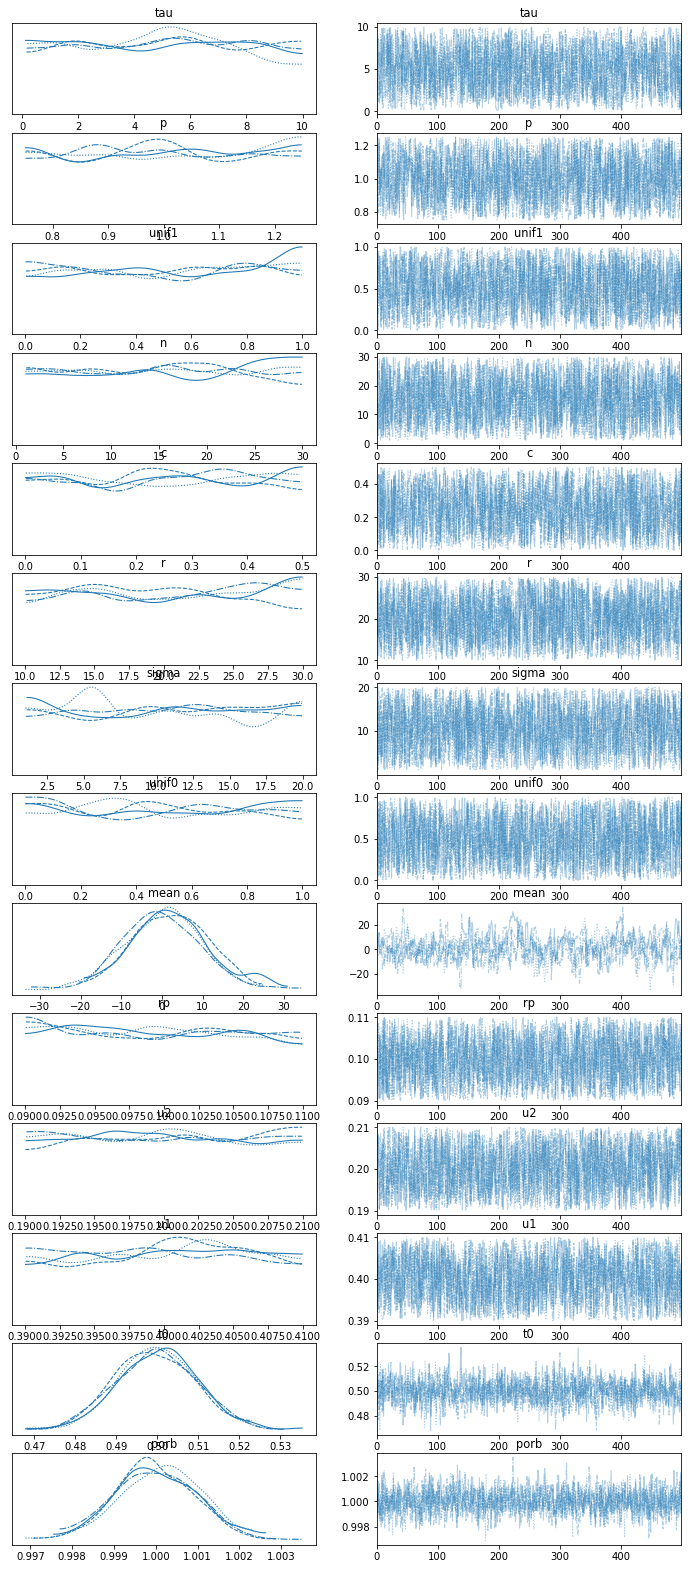

In [81]:
import arviz as az
with model:
    _ = az.plot_trace(trace, var_names=["tau", "p", "unif1", "n", "c", "r", "sigma", "unif0", "mean", "rp", "u2", "u1", "t0", "porb"])

In [103]:
starry.config.lazy = True
with pm.Model() as model:
    # Params for the flux model
    # Orbital parameters for the planet.
    porb = pm.Normal("porb", mu=1.0, sigma=0.001)
    t0 = pm.Normal("t0", mu=0.5, sigma=0.01)
    u1 = pm.Uniform("u1", lower=0.39, upper=0.41)
    u2 = pm.Uniform("u2", lower=0.19, upper=0.21)
    rp = pm.Uniform("rp", lower=0.09, upper=0.11)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly, ecept for the limb-darkening coefficients
    star = starry.Primary(starry.Map())
    planet = starry.Secondary(
        starry.Map(),
        inc=p_inc,
        ecc=p_ecc,
        Omega=p_Omega,
        w=p_w,
        porb=p_porb,
        t0=p_t0
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]

    # Get the flux design matrix
    map = starry.Map(15, len(s_u))
    map.inc = s_inc
    for n, coeff in enumerate(s_u):
        map[n + 1] = coeff
    theta = (360 * t / s_prot) % 360
    A = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=p_r).eval()

    mean = pm.Normal("mean", mu=0.0, sd=10, testval=0)

    # flux_model = pm.Deterministic(
    #         "flux_model", (sys.flux(t)-1)*1e3
    #     )

    # Things we know
    u = [u1,u2]
    ferr = 1e-3

    # Spot latitude params. Isotropic prior on the mode
    # and uniform prior on the standard deviation
    unif0 = pm.Uniform("unif0", 0.0, 1.0)
    mu = 90 - tt.arccos(unif0) * 180 / np.pi
    pm.Deterministic("mu", mu)
    sigma = pm.Uniform("sigma", 1.0, 20.0)

    # Spot radius (uniform prior)
    r = pm.Uniform("r", 10.0, 30.0)

    # Spot contrast & number of spots (uniform prior)
    c = pm.Uniform("c", 0.0, 0.5, testval=0.1)
    n = pm.Uniform("n", 1.0, 30.0, testval=5)

    # Inclination (isotropic prior)
    unif1 = pm.Uniform("unif1", 0.0, 1.0)
    i = tt.arccos(unif1) * 180 / np.pi
    pm.Deterministic("i", i)

    # Period (uniform prior)
    p = pm.Uniform("p", 0.75, 1.25)

    # Variability timescale (uniform prior)
    tau = pm.Uniform("tau", 0.1, 10.0)

    # # Instantiate the GP
    sp = StarryProcess(mu=mu, sigma=sigma, r=r, c=c, n=n)

    # Compute the log likelihood
    # Cov matrix at the ylm basis
    Sigma_ylm = sp.cov_ylm
    K = len(t)

    # Cov matrix
    Sigma = tt.dot(tt.dot(A,Sigma_ylm),A.T)
    Sigma+=1 # adding the baseline
    Sigma += err[0]**2*np.eye(len(t)) # add error to the covariance to make it positive definite
    cho_gp_cov,low = cho_factor(Sigma, lower=True)
    mean1 = tt.reshape(A @ sp.mean_ylm + 1, (K, 1))
    r = (
        tt.reshape(tt.transpose(tt.as_tensor_variable(flux[0])), (K, -1)) # this is for the first light curve!
        - mean1
    )
    M = r.shape[1]
    lnlikemod = -0.5 * tt.sum(
            tt.batched_dot(
                tt.transpose(r), np.transpose(cho_solve((np.asarray(cho_gp_cov),low), r.eval()))
            )
        )
    lnlikemod -= M * tt.sum(tt.log(tt.diag(cho_gp_cov)))
    lnlikemod -= 0.5 * K * M * tt.log(2 * np.pi)

    pm.Deterministic("lnlike", lnlikemod)

ValueError: failed in converting 1st argument `a' of _flapack.dpotrf to C/Fortran array